# Project 3
**Group 2** 
Ada Matilde Gige (adgi@itu.dk), Albert Schiffer (albsc@itu.dk), Andreas Frederik Flensted Olsen (frao@itu.dk), Timothy Beck (tibe@itu.dk) and Victor Popp Henriksen (vhen@itu.dk)


# Imports

In [386]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import seaborn as sns

from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage import transform
from PIL import Image 

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.metrics import classification_report


from os import walk #Used for getting all the filenames from a given directory !!!!!MAYBE NOT NECESSARY!!!!!
import glob #For finding specific file types

%run -i ../fyp2021p3_group00_functions.py

# Loading raw datafiles

In [387]:
#load all images of type .jpg
im_file_list2 = glob.glob("../data/example_image/*.jpg")
#load all maps of type .png
map_file_list2 = glob.glob("../data/example_segmentation/*.png")

#load external images 
im_file_liste = glob.glob("../data/external_data/resized_images/*.jpg")
#Load external maps
map_file_liste = glob.glob("../data/external_data/resized_masks/*.png")

#im_files = sorted(im_file_list2, key = uniq)
im_files = sorted(im_file_list2)
len(im_files)

#map_files = sorted(map_file_list2, key = uniq)
map_files = sorted(map_file_list2)
len(map_files)

#im_files = sorted(im_file_list2, key = uniq)
im_filese = sorted(im_file_liste)
len(im_filese)

#map_files = sorted(map_file_list2, key = uniq)
map_filese = sorted(map_file_liste)
len(map_filese)    



# Loading the true file in
true1 = pd.read_csv('../data/example_ground_truth.csv')
true2 = pd.read_csv('../data/external_data/resized_ISIC-2017_Training_Part3_GroundTruth.csv')

true = pd.concat([true1, true2], ignore_index=True)
# It is already sorted why it is not sorted as the others


true

,image_id,melanoma,seborrheic_keratosis
0,ISIC_0001769,0,0
1,ISIC_0001852,0,0
2,ISIC_0001871,0,0
3,ISIC_0003462,0,0
4,ISIC_0003539,0,0
...,...,...,...
295,ISIC_0015220,0,1
296,ISIC_0015233,0,1
297,ISIC_0015260,0,1
298,ISIC_0015284,1,0


In [388]:
true1

,image_id,melanoma,seborrheic_keratosis
0,ISIC_0001769,0,0
1,ISIC_0001852,0,0
2,ISIC_0001871,0,0
3,ISIC_0003462,0,0
4,ISIC_0003539,0,0
...,...,...,...
145,ISIC_0015443,0,0
146,ISIC_0015445,0,0
147,ISIC_0015483,0,0
148,ISIC_0015496,0,0


### These files are made in this Notebook

## Loading the images into a list and making an ID dictionary
Taken from: https://stackoverflow.com/questions/33369832/read-multiple-images-on-a-folder-in-opencv-python/33371454

In [389]:
#Load in all .jpg files from the 'example_image' folder
#images = [plt.imread(file) for file in im_files]
#Load in all .png files from the 'example_segmentation' folder
#maps = [plt.imread(file) for file in map_files]

images = []
for file in im_files:
    im = Image.open(file)
    im = im.resize((800,500), resample=1) 
    images.append(im)
    
for file in im_filese:
    im = Image.open(file)
    images.append(im)
    
maps = []

for file in map_files:
    ma = Image.open(file)
    ma = ma.resize((800,500), resample=1)
    maps.append(ma)
    
for file in map_filese:
    ma = Image.open(file)
    maps.append(ma)
    

# Making a dictionary to find the id from the index
pic_id = dict()

for i in range(150):
    pic_id[i] = true['image_id'][i]
    

In [ ]:
# Saving the resized images to a folder
'''

for i in range(150):
    im = maps[i]
    path = '../data/example_segmentation_resize/'
    name = str(pic_id[i] + '_segmentation_resized.png')
    pathname = path+name
    im.save(pathname)

'''

# testing features
Making an image as the segmentation masks

In [ ]:
def tolum(image, name):
    '''A function that takes a pictures filename, the picture must be two colored'''
    img = Image.open(image).convert('L')
    img.save(name+'.png')
    return name
    

In [ ]:
def assym(mask, area):

    borders = np.where(mask == 1) # This will return 2 arrays with the index where the pixels are ones
    up, down, left, right = max(borders[0]), min(borders[0]), min(borders[1]), max(borders[1])
    center = ((left + right)//2, (up+down) //2) # Tuple with the coordinates for the center of the lesion
    
    difference = 0
    
    for i in range(18):
        borders = np.where(mask == 1) # This will return 2 arrays with the index where the pixels are ones
        left, right = min(borders[1]), max(borders[1])
        
        
        radiusdiff = (center[0]-left) - (right-center[0])
        difference += radiusdiff**2
        mask = transform.rotate(mask, 10, center = center)
        
    return difference/area

In [ ]:
#tolum('../data/test_pictures/irregular2.png', '../data/test_pictures/irregular2L')

circle = plt.imread('circleL.png')
irregular = plt.imread('../data/test_pictures/irregularL.png')
irregular2 = plt.imread('../data/test_pictures/irregular2L.png')


area1, perimeter1 = measure_area_perimeter(circle)
area2, perimeter2 = measure_area_perimeter(irregular)
area3, perimeter3 = measure_area_perimeter(irregular2)


print('circle', perimeter1/area1, 'irregular', perimeter2/area2, 'irregular2', perimeter3/area3)

assym1 = assym(circle, area1)
assym2 = assym(irregular, area2)
assym3 = assym(irregular2, area3)

print('circle', assym1, 'irregular', assym2, 'irregular2', assym3)

# Features

## Asymmetry

In [ ]:
#A function that finds the center of a picture and meassures the assymmetri

def assymmetry(mapID):
    mask = np.array(maps[mapID])
    
    borders = np.where(mask == 1) # This will return 2 arrays with the index where the pixels are ones
    up, down, left, right = max(borders[0]), min(borders[0]), min(borders[1]), max(borders[1])
    center = ((left + right)//2, (up+down) //2) # Tuple with the coordinates for the center of the lesion
    
    difference = 0
    
    for i in range(18):
        borders = np.where(mask == 1) # This will return 2 arrays with the index where the pixels are ones
        left, right = min(borders[1]), max(borders[1])
        
        
        radiusdiff = (center[0]-left) - (right-center[0])
        difference += radiusdiff**2
        mask = transform.rotate(mask, 10, center = center)
    return difference/areas[mapID]
        

In [ ]:
# Saving it to a file 

asymmetrylist = []

for i in range(300):
    asymmetrylist.append(assymmetry(i))

#np.savetxt("../data/features/assymmetry.csv", asymmetrylist, delimiter=",")

In [ ]:
asymmetry = pd.read_csv("../data/features/assymmetry.csv", names = ['asymmetry'])

## Border
### Area and perimiter

In [ ]:
#Loading the maps in as plt files to be used to find the area an perimiter.

#load all maps of type .png
map_file_area = glob.glob("../data/example_segmentation_resize/*.png")

#Load external maps
map_filee_area = glob.glob("../data/external_data/resized_masks/*.png")


map_files_area = sorted(map_file_area)

map_filese_area = sorted(map_filee_area)   


mapsarea = []

for file in map_files_area:
    im = plt.imread(file)
    mapsarea.append(im)
    
for file in map_filese_area:
    im = plt.imread(file)
    mapsarea.append(im)


In [ ]:
# Finding the area and perimeter of all images. 
'''With the use of morphology.disk(10)'''


areas = []
peris = []
for i in mapsarea:
    area, perimiter = measure_area_perimeter(i)
    areas.append(area)
    peris.append(perimiter)
    
# Adding them to a file, so they don't have to be calculated each time

np.savetxt("../data/features/perimeter10.csv", peris, delimiter=",")
np.savetxt("../data/features/area10.csv", areas, delimiter=",")

In [ ]:
%run -i ../fyp2021p3_group00_functions.py

### Area and perimeter scatterplot

In [ ]:
def scatterplot(area, perimeter):
    # Define the size of the figure
    fig = plt.figure(figsize=(4, 3))
    # Set axes, that you want to work with:
    axes = fig.add_axes([0, 0, 1, 1]) # left, bottom, width, height (range 0 to 1)
    # actually plot the data:
    axes.scatter(area, perimeter, label = 'Data', edgecolors='white')
    axes.set_title('Area and perimeter')
    axes.set_xlabel('Area')
    axes.set_ylabel('Perimeter')
    #axes.legend(loc='upper left'); axes.set_xlabel(data); axes.set_ylabel(data); axes.set_title('Scatter plot');
    return None

In [ ]:
scatterplot(areas, peris)

## Perimeter divided by area

In [ ]:
#making the perimiter divided by area feature

pa = []
for i in range(300): 
    pa.append(perimeter5[i]/areas5[i])
    
# Making a file with the perimeter divided by area feature
#np.savetxt("../data/features/perimeterdivarea5.csv", pa, delimiter=",")

### Making a histogram for the perimeter/area

In [ ]:
sns.histplot(pa, bins = 20)

In [ ]:
sns.histplot(pa, bins = 20)

## Color segmentation

In [ ]:
def color_segmentation(list_of_images, list_of_corresponding_masks): #lists with resized and resampled images
    '''this function takes the 2 lists as input, the one list with images, and the other with its corresponding masks (both resized)
    For each masked image, it performs a felzensvalb algorithim, to compute the segmentation of the mole. The segmentation is 
    normalized (divided by the totalt number of pixels in the mole), and afterwards put into the dataframe as a feature.
    '''
    segmentation = []
    
    for i in range(len(list_of_images)): #the file list
        img1 = list_of_images[i]

        img2 = list_of_corresponding_masks[i]

        img2.paste(img1, (0,0), mask = img2) 

        segments_fz = felzenszwalb(img2, scale=8, sigma=1, min_size=10)

        number_of_segments = len(np.unique(segments_fz))

        normalized_segmentation = round(number_of_segments/(np.sum(list_of_corresponding_masks[i])),7)

        segmentation.append(normalized_segmentation)
    
    return segmentation
    

In [ ]:
#call the function
felz = color_segmentation(images, maps) 

''' Exported as a csv file to avoid future run time
'''

#np.savetxt("../data/features/segmentation.csv", felz, delimiter=",")

In [ ]:
'''To see what is going on inside the loop, is a cutout for only 1 picture in this block of code
'''

img1 = images[0]
img2 = maps[0]
img2.paste(img1, (0,0), mask = img2) 
segments_fz = felzenszwalb(img2, scale=8, sigma=1, min_size=10)
number_of_segments = len(np.unique(segments_fz))
normalized_segmentation = round(number_of_segments/(np.sum(maps[0])),7)
plt.imshow(mark_boundaries(img2, segments_fz))
print('pixels in mask divided by area of mask = ', normalized_segmentation)
#segmenation[images[i]] = normalized_segmentation

In [ ]:
areas5 = np.genfromtxt('../data/features/area5.csv', delimiter=',')
perimeter5 = np.genfromtxt('../data/features/perimeter5.csv', delimiter=',')
areas10 = np.genfromtxt('../data/features/area10.csv', delimiter=',')
perimeter10 = np.genfromtxt('../data/features/perimeter10.csv', delimiter=',')

#pa = np.genfromtxt('../data/features/perimeterdivarea.csv', delimiter=',')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
axes[0].scatter(areas5, perimeter5)
axes[1].scatter(areas10, perimeter10)


# All features in one dataframe

In [390]:
true['unhealthy'] = true['melanoma'] + true['seborrheic_keratosis']

areas = pd.read_csv("../data/features/area5.csv", names = ['area'])
perimeter = pd.read_csv("../data/features/perimeter5.csv", names = ['perimeter'])
pa = pd.read_csv('../data/features/perimeterdivarea5.csv', names = ['peri/area'])
asymmetry = pd.read_csv("../data/features/assymmetry.csv", names = ['asymmetry'])
segmentation = pd.read_csv("../data/features/segmentation.csv", names = ['color segmentation/area'])

true['asymmetry'] = asymmetry
true['area'] = areas
true['perimeter'] = perimeter
true['peri/area'] = pa
true['color segmentation/area'] = segmentation

allfeatures = true
        
allfeatures

,image_id,melanoma,seborrheic_keratosis,unhealthy,asymmetry,area,perimeter,peri/area,color segmentation/area
0,ISIC_0001769,0,0,0,0.000166,14183.917969,2139.917725,0.150869,0.000130
1,ISIC_0001852,0,0,0,0.000408,8563.360352,1552.360840,0.181279,0.000266
2,ISIC_0001871,0,0,0,0.000026,13458.294922,1938.294189,0.144022,0.000097
3,ISIC_0003462,0,0,0,0.000060,10609.465820,1610.466797,0.151795,0.000117
4,ISIC_0003539,0,0,0,0.000553,20800.732422,2366.733398,0.113781,0.000120
...,...,...,...,...,...,...,...,...,...
295,ISIC_0015220,0,1,1,0.000030,291180.437500,8721.486328,0.029952,0.000145
296,ISIC_0015233,0,1,1,0.000384,99675.289062,5080.283203,0.050968,0.000132
297,ISIC_0015260,0,1,1,0.000135,80446.890625,5691.902344,0.070754,0.000228
298,ISIC_0015284,1,0,1,0.000802,153770.343750,6501.336914,0.042280,0.000139


C:\Users\adagi\anaconda3\lib\site-packages\seaborn\axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


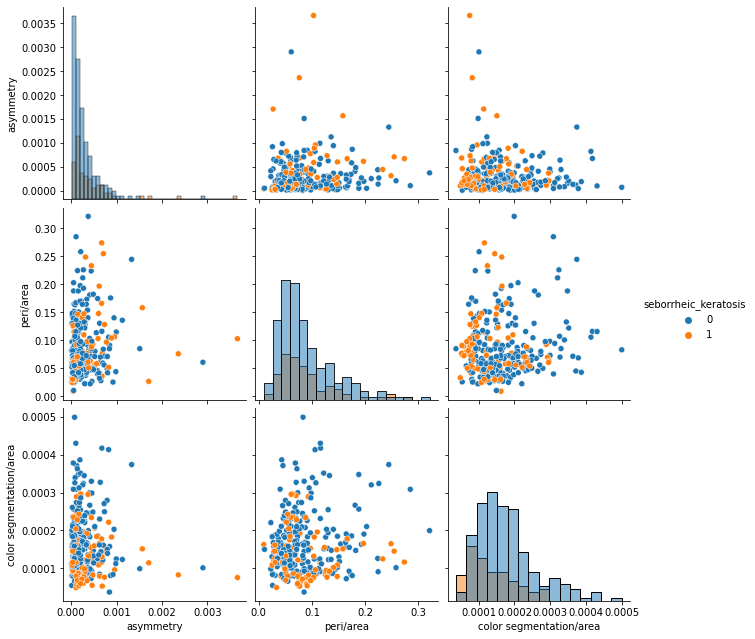

In [391]:
toplot = allfeatures[['asymmetry', 'peri/area','color segmentation/area' ,'unhealthy']]

sns.pairplot(toplot, hue="unhealthy", size=3,diag_kind="hist")

In [ ]:
# Plotting the features

onlyfeatures = allfeatures[[ 'asymmetry', 'peri/area', 'color segmentation/area']]
sns.boxplot(data=onlyfeatures, width=0.5)

7.894919286223335e-18
1.0


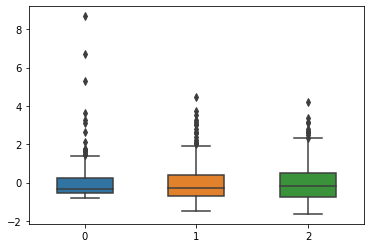

In [392]:
# Scaling the features

#Fit scaler on our data
scaler = preprocessing.StandardScaler().fit(onlyfeatures)

#Apply to data itself
normfeatures = scaler.transform(onlyfeatures)

print(normfeatures.mean()) #small number close to 0, round of error
print(normfeatures.var())  #equal to 1 
sns.boxplot(data=normfeatures, width=0.5,fliersize=5) #we see both negative and positive values, since the mean is 0


C:\Users\adagi\anaconda3\lib\site-packages\seaborn\axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


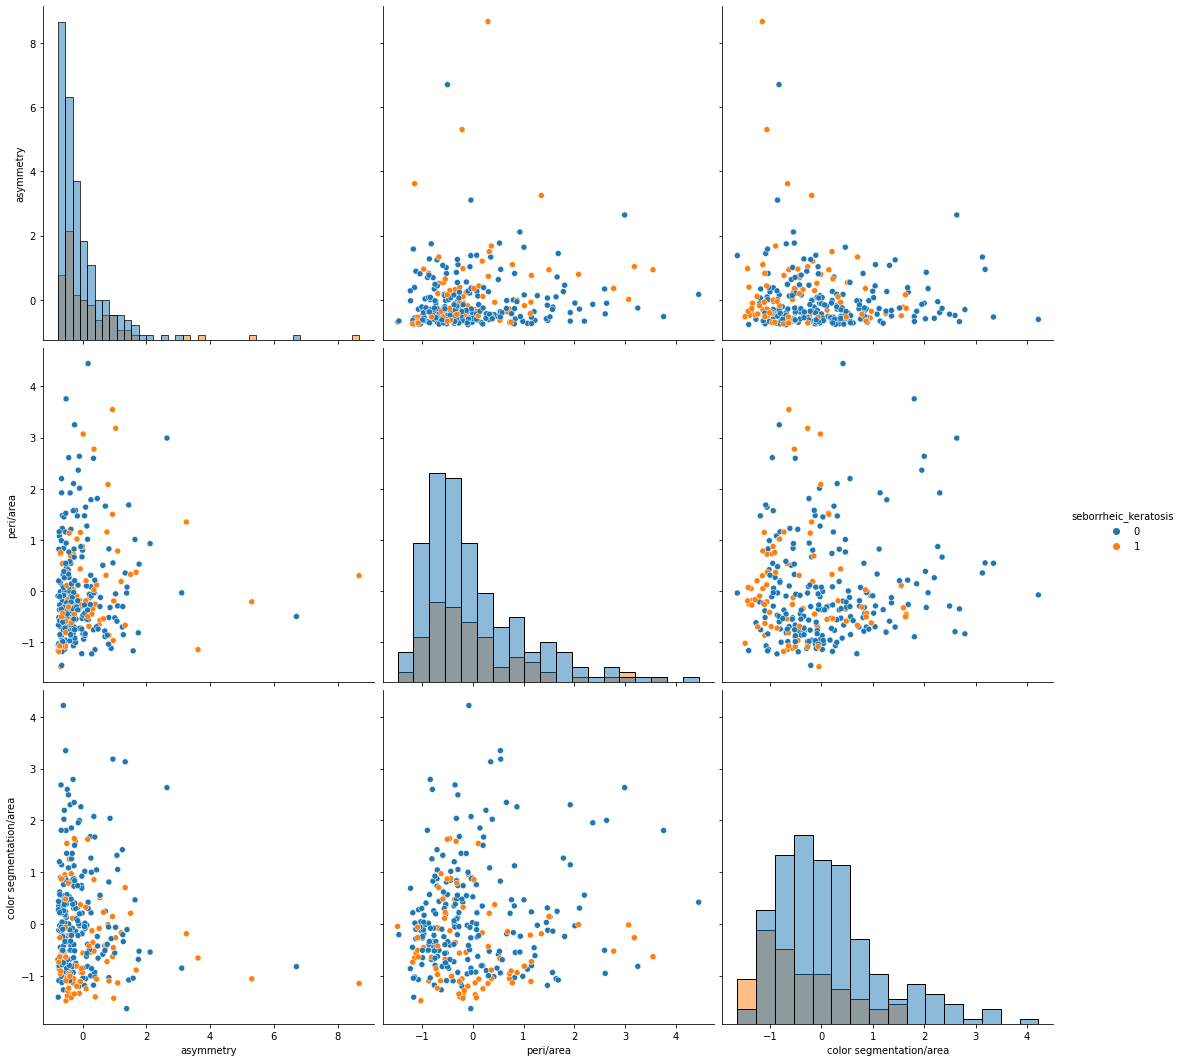

In [444]:
normfeatures = pd.DataFrame(normfeatures, columns = [ 'asymmetry', 'peri/area', 'color segmentation/area'])

# Look at values per class
normfeatures['melanoma'] = allfeatures['melanom']


sns.pairplot(normfeatures, hue="seborrheic_keratosis", size=5,diag_kind="hist")

In [ ]:
# Split the data before feature selection
from sklearn.model_selection import train_test_split

# Some noisy data not correlated
noise = np.random.RandomState(42).uniform(0, 0.1, size=(normfeatures.shape[0], 20))

# Add the noisy data to the informative features
X = np.hstack((normfeatures[['asymmetry', 'peri/area',  'color segmentation/area' ]], noise))
y = normfeatures['seborrheic_keratosis']

# Split dataset to select feature and evaluate the classifier 
# Splitting the data in training 70 % (240/300) validation 10% (30) and test 20% (60) 
X_dev, X_test, y_dev, y_test = train_test_split(
        X, y, stratify=y, random_state=0, test_size = 0.2)

X_train, X_val, y_train, y_val = train_test_split(
        X_dev, y_dev, stratify=y_dev, test_size = 0.125, randomstate = 0)

In [ ]:
# Univariate feature selection with mutual information for feature scoring
selector = SelectKBest(mutual_info_classif, k=2)
selector.fit(X_train, y_train)

scores = selector.scores_

In [ ]:
# Select features that had good scores on training set
X_train1 = X_train[:, [0,3]]
X_train2 = selector.transform(X_train)

# Train a classifier
knn1 = KNeighborsClassifier(n_neighbors=18) # other hyperparameters possible
knn1trained = knn1.fit(X_train2, y_train)

knn2 = KNeighborsClassifier(n_neighbors=18)
knn2trained = knn2.fit(X_train2, y_train)

tree1 = DecisionTreeClassifier() # various hyperparameters
tree1trained = tree1.fit(X_train2, y_train)

svm1 = svm.SVC()
svmtrained = svm1.fit(X_train2, y_train)

In [ ]:
#Select the same features as before
X_val1 = X_val[:, [0,3]]
X_val2 = selector.transform(X_val)

y_val_knn1 = knn1trained.predict(X_val2)
y_val_knn2 = knn2trained.predict(X_val2)
y_val_svm1 = svmtrained.predict(X_val2)
y_val_tree = tree1trained.predict(X_val2)

# Simple accuracy
print(np.sum(y_val_knn1 == y_val) / np.size(y_val) * 100)
print(np.sum(y_val_knn2 == y_val) / np.size(y_val) * 100)
print(np.sum(y_val_svm1 == y_val) / np.size(y_val) * 100)
print(np.sum(y_val_tree == y_val) / np.size(y_val) * 100)

In [ ]:
from sklearn.metrics import accuracy_score

acc_knn1 = accuracy_score(y_val, y_val_knn1)
acc_knn2 = accuracy_score(y_val, y_val_knn2)
acc_svm1 = accuracy_score(y_val, y_val_svm1)
acc_tree = accuracy_score(y_val, y_val_tree)

print(acc_knn1)
print(acc_knn2)
print(acc_svm1)
print(acc_tree)

In [ ]:
from sklearn.metrics import roc_auc_score

auc1 = roc_auc_score(y_val, y_val_knn1)
auc2 = roc_auc_score(y_val, y_val_knn2)
auc3 = roc_auc_score(y_val, y_val_svm1)
auc4 =roc_auc_score(y_val, y_val_tree)

print(auc1)
print(auc2)
print(auc3)
print(auc4)

In [ ]:
''' classification_report on '''

## Cross validation works best only on melanoma

### Before running remember to:
1. Scale the data 
2. Run the normfeature cell with the type (melanoma, keratosis or unhalthy) you want to investigate

In [445]:
## Splitting the data in training 70 % (240/300) validation 10% (30) and test 20% (60)

X = normfeatures[['asymmetry', 'peri/area',  'color segmentation/area' ]]

y = normfeatures['melanoma']

# Split dataset to select feature and evaluate the classifier
X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, random_state=0, test_size = 0.2)


X_train.shape, y_test.shape

((240, 3), (60,))

## Classifying with knn

In [446]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn import metrics

classifier =KNeighborsClassifier(n_neighbors=5) # Firstly the classifier is made
# Then it is trained on the training data by using cross validation cv is the number of splits

scores = cross_val_score(classifier, X_train,  y_train, cv = 5) 
predicted = cross_val_predict(classifier, X_train,  y_train, cv = 5 ) 


print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))


#scorestest = cross_val_score(classifier, X_test,  y_test, cv = 5) 
#predictedtest = cross_val_predict(classifier, X_test,  y_test, cv = 5 )

#print("%0.2f accuracy with a standard deviation of %0.2f" % (scorestest.mean(), scorestest.std()))


#metrics.accuracy_score(y_test, predictedtest)

0.71 accuracy with a standard deviation of 0.05


## Classifying with SVM

In [447]:

classifier = svm.SVC() # Firstly the classifier is made
# Then it is trained on the training data by using cross validation cv is the number of splits

scores = cross_val_score(classifier, X_train,  y_train, cv = 5) 
predicted = cross_val_predict(classifier, X_train,  y_train, cv = 5 ) 


print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))


scorestest = cross_val_score(classifier, X_test,  y_test, cv = 5) 
#predictedtest = cross_val_predict(classifier, X_test,  y_test, cv = 5 )

#print("%0.2f accuracy with a standard deviation of %0.2f" % (scorestest.mean(), scorestest.std()))


#metrics.accuracy_score(y_test, predictedtest)

0.73 accuracy with a standard deviation of 0.00


## Decision tree classifier

In [448]:
classifier = DecisionTreeClassifier() # Firstly the classifier is made
# Then it is trained on the training data by using cross validation cv is the number of splits

scores = cross_val_score(classifier, X_train,  y_train, cv = 5) 
predicted = cross_val_predict(classifier, X_train,  y_train, cv = 5 ) 


print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))


scorestest = cross_val_score(classifier, X_test,  y_test, cv = 5) 
#predictedtest = cross_val_predict(classifier, X_test,  y_test, cv = 5 )

#print("%0.2f accuracy with a standard deviation of %0.2f" % (scorestest.mean(), scorestest.std()))


#metrics.accuracy_score(y_test, predictedtest)

0.65 accuracy with a standard deviation of 0.02
